<a href="https://colab.research.google.com/github/VarunHarish98/ComputerVision/blob/main/Generative_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Varun Hosadurga Harish**

TensorFLow Hub module based on a Generative Adversarial Network (GAN). It maps N-dimensional vectors, called latent space, to RGB images

Two examples are considered:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

In [4]:
# Install imageio for creating animations.
# Installing packages required for the program
# imageio, scikit-image are two packages required
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xzhy8p3z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-xzhy8p3z
  Resolved https://github.com/tensorflow/docs to commit ec765851b8312bdc4dcf685e41020ce568c7bff2
  Preparing metadata (setup.py) ... done


In [5]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# Representing the dimensionality of the latent space
latent_dim = 512

# Interpolation - process of adding frames in between key frames
# Involves normalisation, First normalizes v2 to same norm as v1
# further interpolate between the two vectors on the sphere of higher dimensions
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Display the image
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# For a set of images combine them and create an animation in gif format.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

# Make sure the error level is disabled for unncessary logging
logging.set_verbosity(logging.ERROR)

## Latent space interpolation

In [6]:
# Interpolation of Latent Space
# It contains a pre trained data set required for Progressive Generative Adversarial Network (GAN)
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


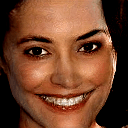

In [7]:
# Generate 2 random vectors for interpolation
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Creating a tensor for 50 steps of interpolation between v1 and v2
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Using the pretrained data for Pregressive GAN to generate images from interpolated vectors
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
# Animate the result
animate(interpolated_images)

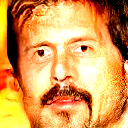

In [8]:
# Fix a target image. As an example use an image generated from the module
# If we want to upload our own image,
# set image_from_module_space as False
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }
# Get a random image from the latent space
def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images
# If uploading image on own, this method is used
def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])
# Choose the target image
if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
# Display the image
display_image(target_image)

In [9]:
# Now define after defining loss function between target and image generated by latent space, minimize the loss
# using gradient descient algorithm
# Gradient Descent Algorithm
#   - If the derivative/gradient is decreasing then move in same direction
#   - else, move in opposite direction
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

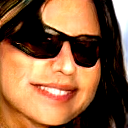

In [10]:
# Display the image
display_image(progan(initial_vector)['default'][0])

In [11]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)
  # Using Adam's optimizer for easy computation steps, learning rate - a hyper parameters
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  # Mean Absolute Error function
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    # For better readability
    if (step % 100)==0:
      print()
    print('.', end='')
    # GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      # If current step is equal to steps_per_image then store the image
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      # CAlculate the mean absolute error for the target image
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to
      # the average length of vector from this distribution.
      # Regularisation of the vector
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    # Get the gradients of the loss with respect to the latent vector.
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 6696.300637817383)

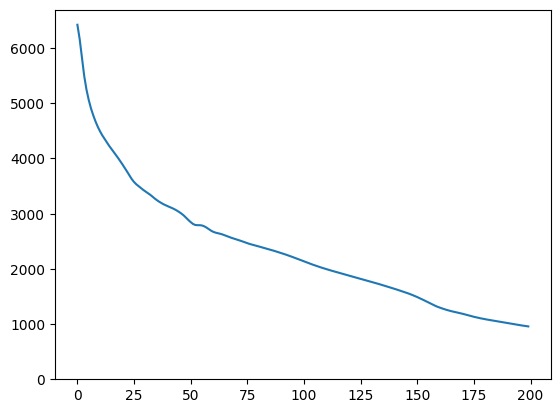

In [12]:
# Plot the loss
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


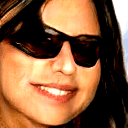

In [13]:
animate(np.stack(images))

**Comparing** the result to the target:

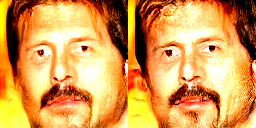

In [14]:
# Displays the last generated image alongside the target image for visual comparison
display_image(np.concatenate([images[-1], target_image], axis=1))

If image is from the module space, the descent is quick and converges to a reasonable sample.  The descent will only converge if the image is reasonably close to the space of training images.

Further ways to descend faster and create a realistic image
* Initializing from a random vector in multiple runs
* Using different loss (quadratic) on the image difference.
* Using different regularizer on the latent vector.

